In [1]:
import pandas as pd
import numpy as np
import glob

# BACI trade dataset
- <b>Goal</b>: Compile the trade dataset to calculate the Herfindahl–Hirschman Index (HHI) for trade dyversity (Shepard 2020), and trade gravity indices normalized to share of trade. These will be used for further regression analysis
    - HHI: The stronger the link of specific product trade is with only a limited number of countries and therefore the stronger the geographical concentration, the higher the index. 
- The dataset covers information between 1995-2021 for 239 countries.
- Products code of interest:
    - 271111: Petroleum gases and other gaseous hydrocarbons: liquefied, natural gas --> for LNG terminals
    - 271121: Petroleum gases and other gaseous hydrocarbons: in gaseous state, natural gas --> for pipelines
    - 270111: Coal: anthracite, whether or not pulverised, but not agglomerated
    - 270112: Coal: bituminous, whether or not pulverised, but not agglomerated
    - 270119: Coal: (other than anthracite and bituminous), whether or not pulverised but not agglomerated
- <b>Assumptions</b>:
    - The DGD variables are calculated on import and export basis and normalized to the value market share of each commodity trade (--> further improvement on normalization basis??)
    - Any present trade agreement or sanction ->  binary = 1
    - When checking colony relationships, use "whether the country is a colony of the destination" for export, and vice versa
- <b>Notes</b>: !!! only calculating LNG import export for now... --> will work on coal and gaseous natural gas transport later

In [2]:
BACI_dir = "../../data/global_BACI/"

In [3]:
import warnings
warnings.filterwarnings("ignore")

### select the relevant commodities

In [4]:
dirpath = "BACI_HS92_V202301/BACI*.csv"
fpaths = glob.glob(BACI_dir+dirpath)

In [5]:
gas_code = [271111,271121]
coal_code = [270111, 270112, 270119]
all_products = gas_code + coal_code
all_products

[271111, 271121, 270111, 270112, 270119]

In [6]:
product_data = pd.read_csv("_selected_commodity_temporal.csv")
product_data

,t,i,j,k,v,q
0,1995,12,58,271111,278491.211,2561632.546
1,1995,12,148,271121,2664.360,NA
2,1995,12,251,271111,469076.300,4375529.295
3,1995,12,380,271111,406.369,2788.875
4,1995,12,380,271121,1205499.904,NA
...,...,...,...,...,...,...
76439,2021,894,178,270112,352.045,2423.440
76440,2021,894,180,270112,5977.039,52653.227
76441,2021,894,180,270119,2769.487,31012.460
76442,2021,894,454,270112,58.842,988.300


### convert country code for country iso 

In [7]:
country_table = pd.read_csv(BACI_dir+"BACI_HS92_V202301/country_codes_V202301.csv")
country_table.head()

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND


In [8]:
product_data_c1 = pd.merge(product_data,country_table[["country_code","iso_3digit_alpha"]],
                                left_on="i",right_on="country_code")
product_data_c1 = product_data_c1.rename(columns={"iso_3digit_alpha":"iso_o"})                                    
product_data_c1 = product_data_c1.drop(columns=["i","country_code"])
product_data_c2 = pd.merge(product_data_c1,country_table[["country_code","iso_3digit_alpha"]],
                                left_on="j",right_on="country_code")
product_data_c2 = product_data_c2.rename(columns={"iso_3digit_alpha":"iso_d"}) 
product_data_c2 = product_data_c2.drop(columns=["j","country_code"])
product_data_c2.head()

,t,k,v,q,iso_o,iso_d
0,1995,271111,278491.211,2561632.546,DZA,BEL
1,1996,271111,327819.389,2778718.192,DZA,BEL
2,1997,271111,461068.302,3520685.919,DZA,BEL
3,1998,271111,378720.244,3599331.946,DZA,BEL
4,1995,270111,3463.441,103417.730,AUS,BEL


In [58]:
gas_products = product_data_c2[product_data_c2["k"].isin(gas_code)]
gas_products = gas_products.replace('           NA',0)
gas_products["v"] = gas_products["v"].astype(float)
gas_products["q"] = gas_products["q"].astype(float)
gas_products["v/q"] = gas_products["v"]/gas_products["q"]#
gas_products_ukr = gas_products.query("iso_d=='IND'").groupby(["iso_o","iso_d","t"]).sum()
gas_products_ukr = gas_products_ukr.reset_index()
gas_products_ukr

,iso_o,iso_d,t,k,v,q,v/q
0,AGO,IND,2016,271111,99500.347,346358.648,0.287275
1,AGO,IND,2017,271111,292769.751,973929.848,0.300607
2,AGO,IND,2018,271111,564474.035,1359599.205,0.415177
3,AGO,IND,2019,271111,745215.703,2225530.177,0.334849
4,AGO,IND,2020,271111,510198.296,2206146.949,0.231262
...,...,...,...,...,...,...,...
292,ZAF,IND,2010,271111,24578.203,55497.000,0.442874
293,ZAF,IND,2015,271111,202624.457,413438.288,0.490096
294,ZAF,IND,2016,271111,65643.714,175646.680,0.373726
295,ZAF,IND,2017,271111,12160.104,39766.500,0.305788


In [18]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='t', ylabel='v'>

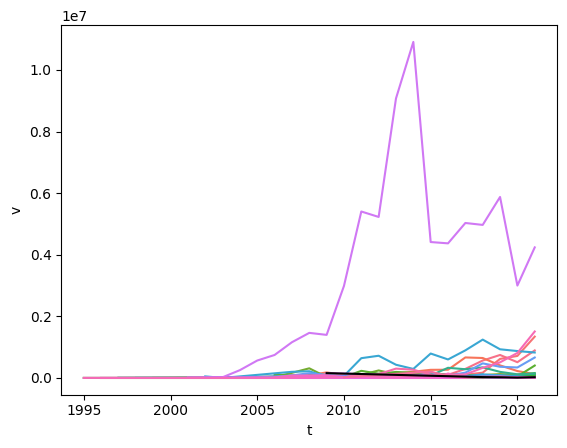

In [64]:
sns.lineplot(x="t", y="v",hue="iso_o",data=gas_products_ukr,legend=None)
sns.lineplot(x="t", y="v",data=gas_products_ukr.query("iso_o=='RUS'"),color="black")

<Axes: xlabel='t', ylabel='v'>

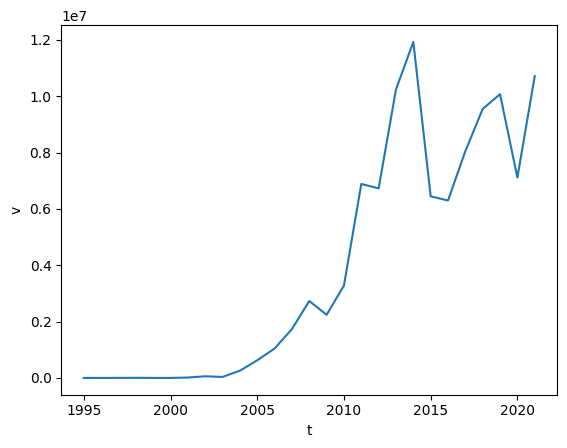

In [66]:
gas_products_ukr_sum = gas_products_ukr.groupby("t").sum()
gas_products_ukr_sum = gas_products_ukr_sum.reset_index()
sns.lineplot(x="t", y="v",data=gas_products_ukr_sum,legend=None)

### LNG import export

In [67]:
dynamic_files = glob.glob("_temporal_dynamic_gravity*.csv")
dynamic_files

['_temporal_dynamic_gravity_1948_1959.csv',
 '_temporal_dynamic_gravity_1960_1969.csv',
 '_temporal_dynamic_gravity_1970_1979.csv',
 '_temporal_dynamic_gravity_1980_1989.csv',
 '_temporal_dynamic_gravity_1990_1999.csv',
 '_temporal_dynamic_gravity_2000_2004.csv',
 '_temporal_dynamic_gravity_2005_2009.csv',
 '_temporal_dynamic_gravity_2010_2014.csv',
 '_temporal_dynamic_gravity_2015_2019.csv']

In [68]:
for dfile in dynamic_files:
    sliced_data = pd.read_csv(dfile)
    if dfile == dynamic_files[0]:
        DGD_data = sliced_data
    else:
        DGD_data = pd.concat([DGD_data,sliced_data])
DGD_data

,year,iso3_o,iso3_d,contiguity,agree_cu,agree_eia,agree_fta,agree_psa,agree_pta,sanction_threat,sanction_imposition,common_language,colony_of_destination_ever,colony_of_origin_ever
0,1948,AFG,ALA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,1949,AFG,ALA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,1950,AFG,ALA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,1951,AFG,ALA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,1952,AFG,ALA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449829,2021,ZWE,WLF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0.0,0.0
449830,2021,ZWE,WSM,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1,0.0,0.0
449831,2021,ZWE,YEM,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0.0,0.0
449832,2021,ZWE,ZAF,1.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,1,0.0,0.0


In [69]:
# compile the dynamic gravity dataset to compile some variables
# the "agree" and "sanction" variables capture any agreements or sanctions 
edit_list = ["agree","sanction"]
original_list = [['agree_cu', 'agree_eia', 'agree_fta', 'agree_psa', 'agree_pta'],['sanction_threat', 'sanction_imposition']]
for edit_name in edit_list:
    edit_index = edit_list.index(edit_name)
    orig_names = original_list[edit_index]
    DGD_data[edit_name] = DGD_data[orig_names].sum(axis=1)
    positive_countries = DGD_data[DGD_data[edit_name]>0]
    positive_countries_index = positive_countries.index
    DGD_data.loc[positive_countries_index,edit_name] = 1
    DGD_data = DGD_data.drop(columns=orig_names)
DGD_data

,year,iso3_o,iso3_d,contiguity,common_language,colony_of_destination_ever,colony_of_origin_ever,agree,sanction
0,1948,AFG,ALA,0.0,0,0.0,0.0,0.0,0.0
1,1949,AFG,ALA,0.0,0,0.0,0.0,0.0,0.0
2,1950,AFG,ALA,0.0,0,0.0,0.0,0.0,0.0
3,1951,AFG,ALA,0.0,0,0.0,0.0,0.0,0.0
4,1952,AFG,ALA,0.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
449829,2021,ZWE,WLF,0.0,0,0.0,0.0,0.0,0.0
449830,2021,ZWE,WSM,0.0,1,0.0,0.0,0.0,0.0
449831,2021,ZWE,YEM,0.0,0,0.0,0.0,0.0,0.0
449832,2021,ZWE,ZAF,1.0,1,0.0,0.0,1.0,0.0


In [85]:
def calculate_trade_var(commodity,mode):
    """
    commodity = "LNG", "GNG", "Coal"
    mode = "Import", "Export"
    """
    # select the dynamic gravity variables of interest
    DGD_cols = ['contiguity', 'agree', 'sanction', 'sanction','common_language','colony']
    
    # assign the list of commodity code based on commodity name
    if commodity == "LNG":
        code_list = [271111]
    elif commodity == "GNG":
        code_list = [271121]
    elif commodity == "Coal":
        code_list = coal_code
    elif commodity == "Gas":
        code_list = gas_code
    
    # select the product of interest
    product_data_c2[["v","q"]] = product_data_c2[["v","q"]].replace('           NA',np.nan)
    product_data_c2["v"] = product_data_c2["v"].astype(float)
    product_data_c2["q"] = product_data_c2["q"].astype(float)
    this_comodity = product_data_c2[product_data_c2["k"].isin(code_list)]
    this_comodity = this_comodity.groupby(["t","iso_o","iso_d"]).sum()
    this_comodity = this_comodity.reset_index()
    this_comodity_DGD = pd.merge(this_comodity,DGD_data,left_on = ["t","iso_o","iso_d"], right_on = ["year","iso3_o","iso3_d"],how="left")
    this_comodity_DGD = this_comodity_DGD.drop(columns=["t","iso_o","iso_d"])
    this_comodity_DGD = this_comodity_DGD.fillna(0)
    
    # assign the column name of country based on import export mode 
    if mode == "Export":
        iso_mode = "iso3_o" # origin country
        colony_mode = 'colony_of_destination_ever' # check whether the exporter has been a colony
    elif mode == "Import":
        iso_mode = "iso3_d" # destination country 
        colony_mode = 'colony_of_origin_ever' # # check whether the importer has been a colony
        
    country_list = this_comodity_DGD[iso_mode].unique()
    name_descript = "_"+commodity+"_"+mode
    # calculate the variables based on year and import/export country
    for country_select in country_list:
        this_comodity_select = this_comodity_DGD[this_comodity_DGD[iso_mode]==country_select]
        year_list = this_comodity_select["year"].unique()
        for year_select in year_list:
            this_commodity_select_yr = this_comodity_select[this_comodity_select["year"]==year_select]
            # calculate the sum of import/export values
            select_yr_val_sum = this_commodity_select_yr["q"].sum()
            # share of exporter/importer to calculate the Herfindahl–Hirschman Index
            this_commodity_select_yr["share"] = this_commodity_select_yr["q"]/select_yr_val_sum
            this_commodity_select_yr["HHI"+name_descript] = this_commodity_select_yr["share"]**2
            this_commodity_select_yr["Value"+name_descript] = this_commodity_select_yr["v"]
            this_commodity_select_yr["Quantity"+name_descript] = this_commodity_select_yr["q"]
            this_commodity_select_yr["colony"] = this_commodity_select_yr[colony_mode]
            # normalize all the dynamic gravity variables based on the value share of import/export
            for dgd in DGD_cols:
                this_commodity_select_yr[dgd+name_descript] = this_commodity_select_yr[dgd]*this_commodity_select_yr["share"] 
            result_cols = [col for col in this_commodity_select_yr.columns if name_descript in col]
            result_df = pd.DataFrame(data=this_commodity_select_yr[result_cols].sum()).rename(columns={0:year_select})
            if year_select == year_list[0]:
                result_country = result_df
            else:
                result_country = pd.concat([result_country,result_df],axis=1)
        result_country_tr = result_country.transpose()
        result_country_tr = result_country_tr.reset_index().rename(columns={"index":"year"})
        result_country_tr["country"] = country_select
        if country_select == country_list[0]:
            result_all_country = result_country_tr
        else:
            result_all_country = pd.concat([result_all_country,result_country_tr],axis=0)
    result_all_country = result_all_country.set_index(["country","year"])
    return result_all_country

### calculate the LNG Import Export variables 

In [86]:
lng_export_data = calculate_trade_var("LNG","Export")
lng_export_data.to_csv("_temporal_BACI_DGD_LNG_Export.csv")
lng_import_data = calculate_trade_var("LNG","Import")
lng_import_data.to_csv("_temporal_BACI_DGD_LNG_Import.csv")
# combine both datasets
lng_data = pd.concat([lng_import_data,lng_export_data],axis=1)
lng_data = lng_data.fillna(0)
lng_data ["NetValue_LNG_Import"] = lng_data ["Value_LNG_Import"]-lng_data ["Value_LNG_Export"]
lng_data.to_csv("_temporal_BACI_DGD_LNG_both.csv")
lng_data

HHI_LNG_Import  Value_LNG_Import  Quantity_LNG_Import  \
country year                                                            
BEL     1995.0        0.798838        315268.923          2876914.985   
        1996.0        0.979502        331257.747          2807786.807   
        1997.0        1.000000        461068.874          3520686.106   
        1998.0        0.999942        378732.628          3599436.398   
        1999.0        0.999079        289145.118          3237086.576   
...                        ...               ...                  ...   
VCT     2020.0        0.000000             0.000                0.000   
MNE     2016.0        0.000000             0.000                0.000   
CYM     2018.0        0.000000             0.000                0.000   
ASM     2019.0        0.000000             0.000                0.000   
GNB     2021.0        0.000000             0.000                0.000   

                contiguity_LNG_Import  agree_LNG_Import  sanction_LNG_Import  \
country year                                                                   
BEL     1995.0               0.051439          1.000000             0.000000   
        1996.0               0.010031          1.000000             0.000000   
        1997.0               0.000000          1.000000             0.000000   
        1998.0               0.000029          1.000000             0.000000   
        1999.0               0.000425          0.999964             0.000036   
...                               ...               ...                  ...   
VCT     2020.0               0.000000          0.000000             0.000000   
MNE     2016.0               0.000000          0.000000             0.000000   
CYM     2018.0               0.000000          0.000000             0.000000   
ASM     2019.0               0.000000          0.000000             0.000000   
GNB     2021.0               0.000000          0.000000             0.000000   

                common_language_LNG_Import  colony_LNG_Import  HHI_LNG_Export  \
country year                                                                    
BEL     1995.0                    0.941849           0.000000        0.890259   
        1996.0                    0.999679           0.000000        1.000000   
        1997.0                    1.000000           0.000000        1.000000   
        1998.0                    1.000000           0.000009        1.000000   
        1999.0                    0.999964           0.000000        0.998075   
...                                    ...                ...             ...   
VCT     2020.0                    0.000000           0.000000        1.000000   
MNE     2016.0                    0.000000           0.000000        1.000000   
CYM     2018.0                    0.000000           0.000000        1.000000   
ASM     2019.0                    0.000000           0.000000        1.000000   
GNB     2021.0                    0.000000           0.000000        1.000000   

                Value_LNG_Export  Quantity_LNG_Export  contiguity_LNG_Export  \
country year                                                                   
BEL     1995.0             9.699               16.985               0.942008   
        1996.0             0.659                0.020               0.000000   
        1997.0            90.349             1109.437               0.000000   
        1998.0             0.685                0.296               0.000000   
        1999.0            76.667              100.675               0.000963   
...                          ...                  ...                    ...   
VCT     2020.0         54089.686           225312.732               0.000000   
MNE     2016.0             0.065                0.010               0.000000   
CYM     2018.0             0.131                0.365               0.000000   
ASM     2019.0             1.766                0.100               0.000000   
GNB     202

In [95]:
gas_export_data = calculate_trade_var("Gas","Export")
gas_export_data.to_csv("_temporal_BACI_DGD_Gas_Export.csv")
gas_import_data = calculate_trade_var("Gas","Import")
gas_import_data.to_csv("_temporal_BACI_DGD_Gas_Import.csv")

In [93]:
# combine both datasets
gas_data = pd.concat([gas_import_data,gas_export_data],axis=1)
gas_data = gas_data.fillna(0)
gas_data["NetValue_Gas_Import"] = gas_data["Value_Gas_Import"]-gas_data["Value_Gas_Export"]
gas_data["NetQuantity_Gas_Import"] = gas_data["Quantity_Gas_Import"]-gas_data["Quantity_Gas_Export"]
gas_data = gas_data.drop(columns=["Value_Gas_Import","Value_Gas_Export","Quantity_Gas_Import","Quantity_Gas_Export"])
gas_data.to_csv("_temporal_BACI_DGD_Gas_both.csv")

In [88]:
coal_export_data = calculate_trade_var("Coal","Export")
coal_export_data.to_csv("_temporal_BACI_DGD_Coal_Export.csv")
coal_import_data = calculate_trade_var("Coal","Import")
coal_import_data.to_csv("_temporal_BACI_DGD_Coal_Import.csv")

In [94]:
# combine both datasets
coal_data = pd.concat([coal_import_data,coal_export_data],axis=1)
coal_data = coal_data.fillna(0)
coal_data["NetValue_Coal_Import"] = coal_data["Value_Coal_Import"]-coal_data["Value_Coal_Export"]
coal_data["NetQuantity_Coal_Import"] = coal_data["Quantity_Coal_Import"]-coal_data["Quantity_Coal_Export"]
coal_data = coal_data.drop(columns=["Value_Coal_Import","Value_Coal_Export","Quantity_Coal_Import","Quantity_Coal_Export"])
coal_data.to_csv("_temporal_BACI_DGD_Coal_both.csv")